In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [2]:
# Load the dataset
df = pd.read_csv('../data/preprocessed/df_agg_area.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1097 non-null   object
 1   vacancies    1097 non-null   int64 
 2   area_BROCK   1097 non-null   int64 
 3   area_EXCH    1097 non-null   int64 
 4   area_FRASER  1097 non-null   int64 
 5   area_GREEN   1097 non-null   int64 
 6   area_IONA    1097 non-null   int64 
 7   area_KWTQ    1097 non-null   int64 
 8   area_MARINE  1097 non-null   int64 
 9   area_POND    1097 non-null   int64 
 10  area_STJOHN  1097 non-null   int64 
 11  area_TBIRD   1097 non-null   int64 
 12  area_AP_UA   1097 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 111.5+ KB


In [4]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.rename(columns={'date': 'ds'}, inplace=True)
df

,ds,vacancies,area_BROCK,area_EXCH,area_FRASER,area_GREEN,area_IONA,area_KWTQ,area_MARINE,area_POND,area_STJOHN,area_TBIRD,area_AP_UA
0,2021-11-01,74,1,5,2,7,0,0,23,6,2,11,17
1,2021-11-02,91,2,5,2,7,0,0,25,7,5,12,26
2,2021-11-03,93,2,5,2,7,0,0,25,7,4,13,28
3,2021-11-04,95,2,5,2,7,0,0,26,7,5,13,28
4,2021-11-05,93,2,5,2,7,0,0,26,7,5,12,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,2024-10-28,36,3,0,0,1,0,1,12,2,4,5,8
1093,2024-10-29,34,2,0,0,1,0,1,12,2,4,5,7
1094,2024-10-30,34,2,0,0,1,0,1,12,3,4,4,7
1095,2024-10-31,34,2,0,0,1,0,1,12,3,4,4,7


In [6]:
# Melt the dataframe to convert from wide to long format
df_long = df.melt(id_vars=['ds'], var_name='area', value_name='y')

# Preview the melted data
print(df_long.head())

          ds       area   y
0 2021-11-01  vacancies  74
1 2021-11-02  vacancies  91
2 2021-11-03  vacancies  93
3 2021-11-04  vacancies  95
4 2021-11-05  vacancies  93


In [7]:
area ='area_POND'

# Extract year and month to group by month
df['year_month'] = df['ds'].dt.to_period('M')

# Find the date with the maximum vacancies for each month
idx = df.groupby('year_month')[area].idxmax()

# Retrieve the rows with the maximum vacancies
max_vacancy_per_month = df.loc[idx, ['ds', 'year_month', area]].reset_index(drop=True)

# Rename columns for clarity
max_vacancy_per_month.rename(columns={'ds': 'Date', 'year_month': 'Month', area: 'Max Pond Vacancies'}, inplace=True)

# Display the result
print(max_vacancy_per_month)

         Date    Month  Max Pond Vacancies
0  2021-11-02  2021-11                   7
1  2021-12-28  2021-12                  34
2  2022-01-01  2022-01                  24
3  2022-02-02  2022-02                  12
4  2022-03-15  2022-03                  15
5  2022-04-30  2022-04                 262
6  2022-05-02  2022-05                 276
7  2022-06-11  2022-06                  36
8  2022-07-07  2022-07                  17
9  2022-08-29  2022-08                  19
10 2022-09-02  2022-09                  10
11 2022-10-02  2022-10                   7
12 2022-11-02  2022-11                   5
13 2022-12-27  2022-12                  37
14 2023-01-02  2023-01                  20
15 2023-02-19  2023-02                   6
16 2023-03-01  2023-03                   2
17 2023-04-30  2023-04                 196
18 2023-05-02  2023-05                 197
19 2023-06-06  2023-06                  75
20 2023-07-04  2023-07                  18
21 2023-08-27  2023-08                  16
22 2023-09-

In [8]:
# Define holidays
holidays = pd.DataFrame({
  'holiday': 'move_out',
  'ds': pd.to_datetime(['2022-04-30', '2022-05-02', '2022-12-27', '2023-04-30', '2023-05-02', 
                        '2023-06-06', '2023-12-31', '2024-04-30', '2024-05-02', '2024-06-02']),  # move-out dates
    'lower_window': [-2, 0, -4, -2, 0, -4, -8, -2, 0, -2],
    'upper_window': [1, 2, 6, 1, 3, 0, 5, 1, 2, 0]
})

20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing


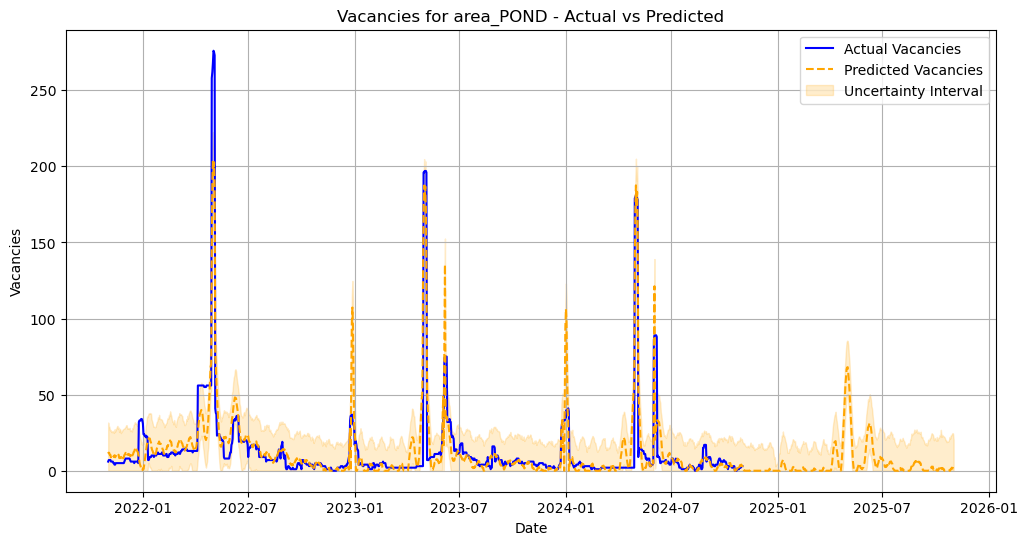

  0%|          | 0/2 [00:00<?, ?it/s]

20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:07 - cmdstanpy - INFO - Chain [1] done processing
20:31:07 - cmdstanpy - INFO - Chain [1] start processing
20:31:07 - cmdstanpy - INFO - Chain [1] done processing


   horizon          mse       rmse        mae      mdape     smape  coverage
0   9 days    29.950423   5.472698   4.768728   1.796179  1.375885  1.000000
1  10 days    35.064769   5.921551   5.239970   2.525367  1.407476  1.000000
2  11 days    41.076697   6.409110   5.800316   3.533682  1.459747  1.000000
3  12 days    44.710984   6.686627   6.180684   3.607163  1.492094  1.000000
4  13 days    47.178756   6.868679   6.491163   3.668029  1.548278  1.000000
..     ...          ...        ...        ...        ...       ...       ...
77 86 days  1392.662863  37.318398  27.009792  11.431813  1.646217  0.555556
78 87 days  1338.219408  36.581681  25.685816   6.255977  1.550541  0.611111
79 88 days  1254.778877  35.422858  24.319616   4.107029  1.454620  0.611111
80 89 days  1099.315158  33.155922  21.422933   2.589277  1.351560  0.666667
81 90 days  1105.615379  33.250795  21.472325   2.378275  1.334194  0.666667

[82 rows x 7 columns]


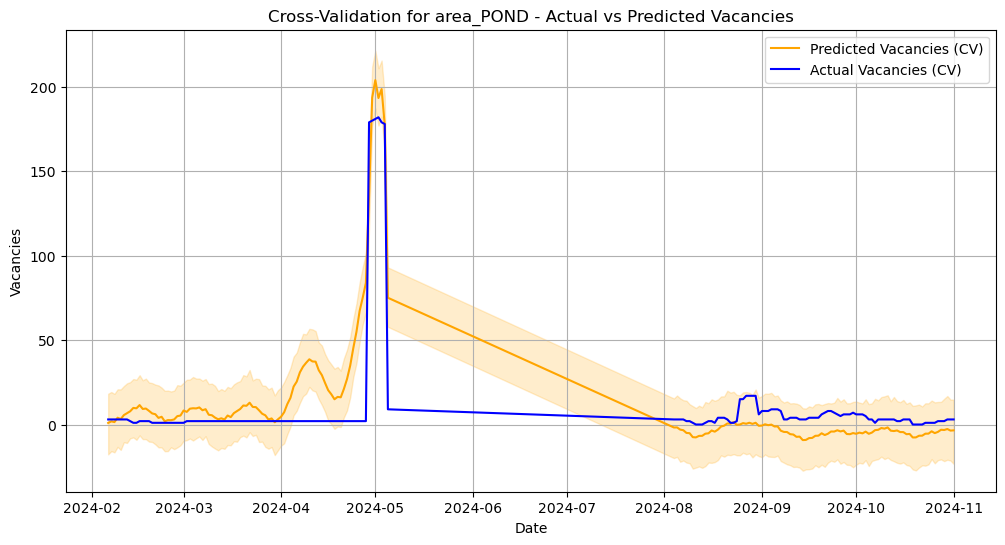

In [14]:
# Load your dataset for a single area
area = 'area_POND'  # Replace with your area column name
df_pond = df[['ds', area]].rename(columns={area: 'y'})
# df_marine['end_of_month'] = df_marine['ds'].dt.is_month_end.astype(int)
# Initialize Prophet model
model = Prophet(holidays=holidays, 
                yearly_seasonality=20,
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=15,
                seasonality_mode='additive')

# Add 'is_end_of_month' as a regressor
# model.add_regressor('end_of_month')

# Fit the model
model.fit(df_pond)

# Predict on future (1 year ahead)
future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot the forecast with actual values
plt.figure(figsize=(12, 6))
plt.plot(df_pond['ds'], df_pond['y'], label="Actual Vacancies", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Vacancies", color='orange', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label="Uncertainty Interval")
plt.title(f"Vacancies for {area} - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/forecasted_pond.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-validation:
# Set up cross-validation for Prophet
cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')

# Performance Metrics:
# Evaluate the performance of the model on the cross-validation results
metrics = performance_metrics(cv_results)
print(metrics)

# Plot Cross-Validation Results:
plt.figure(figsize=(12, 6))
plt.plot(cv_results['ds'], cv_results['yhat'], label="Predicted Vacancies (CV)", color='orange')
plt.plot(cv_results['ds'], cv_results['y'], label="Actual Vacancies (CV)", color='blue')
plt.fill_between(cv_results['ds'], cv_results['yhat_lower'], cv_results['yhat_upper'], color='orange', alpha=0.2)
plt.title(f"Cross-Validation for {area} - Actual vs Predicted Vacancies")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
forecast.to_csv('../data/predictions/forecast_pond.csv', index = False)
df_pond.to_csv('../data/predictions/df_pond.csv', index = False)